# Data Analysis

## 1. Loading the data

In [1]:
from google.colab import drive
import sys

In [2]:
sys.path.append('drive/MyDrive/')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import re
import nltk
nltk.download('punkt_tab')
from nltk import sent_tokenize
import pandas as pd

cg_sents = []
smg_sents = []
eval_sents=[]

def remove_duplicate_punctuation(s): # sent_tokenize() gets confused when there's duplicate punctuation
    return re.sub(r'([\.\?!;])\1+', r'\1 ', s)  # In a previous version of this I used r'\1' instead of r'\1 '. However it caused a problem for sentences like "this is great...I don't know what to do." It seems that some people do not use spacing with ellipses which caused sent_tokenize() to not identify a new sentence.

def fix_new_sentence_spacing(s):
    return re.sub(r'([a-zα-ωίϊΐόάέύϋΰήώ])([\.\?!;])([A-ZΑ-ΩΆΈΊΌΎΏΉ])', r'\1\2 \3', s) # https://stackoverflow.com/questions/44858741/nltk-tokenizer-and-stanford-corenlp-tokenizer-cannot-distinct-2-sentences-withou

file = pd.read_csv("/content/drive/MyDrive/stories-train.csv")
for text in file['text']:
    text = remove_duplicate_punctuation(text)
    text = fix_new_sentence_spacing(text)
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        cg_sents += sent_tokenize(line)

with open('/content/drive/MyDrive/paramithia.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    text = fix_new_sentence_spacing(text)
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        smg_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/paramithia.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   eval_sents += sent_tokenize(line)

file = pd.read_csv("/content/drive/MyDrive/val.csv")
for text in file['text']:
    text = remove_duplicate_punctuation(text)
    text = fix_new_sentence_spacing(text)
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        eval_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/Data/cg_fb.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   cg_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/Data/cg_other.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   cg_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/Data/smg_twitter.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   smg_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/Data/smg_fb.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   smg_sents += sent_tokenize(line)

#with open('/content/drive/MyDrive/Data/smg_other.txt', 'r', encoding='utf-8') as in_file:
 #   text = remove_duplicate_punctuation(in_file.read())
  #  text = fix_new_sentence_spacing(text)
   # lines = [p for p in text.split('\n') if p]
    #for line in lines:
     #   smg_sents += sent_tokenize(line)


cg_sents[:3]
print(len(eval_sents))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


656


## 2. Cleaning the data

In [4]:
import unicodedata
from string import punctuation
from nltk.tokenize import WhitespaceTokenizer
from transformers import AutoTokenizer

punctuation += '´΄’…“”–—―»«' # string.punctuation misses these.

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def get_clean_sent_el(sentence):
    sentence = re.sub(r'^RT', '', sentence)
    sentence = re.sub(r'\&\w*;', '', sentence)
    sentence = re.sub(r'\@\w*', '', sentence)
    sentence = re.sub(r'\$\w*', '', sentence)
    sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)
    sentence = ''.join(c for c in sentence if c <= '\uFFFF')
    sentence = strip_accents(sentence)
    sentence = re.sub(r'#\w*', '', sentence)
    sentence = sentence.lower()
    tokens = WhitespaceTokenizer().tokenize(sentence)
    new_tokens = []
    for token in tokens:
        if token == 'ο,τι' or token == 'ό,τι' or token == 'o,ti' or token == 'ó,ti':
            new_tokens.append(token)
        else:
            token = re.sub(r'(?<=[.,!\?;\'΄´’])(?=[^\s])', r' ', token) # If there is punctuation not followed by a space, we add it. I also added a space after apostrophes because I want something like σαγαπώ to not be considered as one word.
            new_token = token.translate(str.maketrans({key: None for key in punctuation}))
            if new_token != '': # This might happen if a user surrounds commas with spaces , like so.
                new_tokens.append(new_token)
    sentence =' '.join(new_tokens)
    sentence = sentence.replace('\ufeff', '') # \ufeff might appear when dealing with unicode-encoded files
    sentence = sentence.strip(' ') # performs lstrip() and rstrip()
    sentence = sentence.replace('  ', ' ') # Adding a space after the apostrophe can lead to the appearance of double spaces if apostrophes are used along with spaces in the original text.
    return sentence

cg_sents_clean = []
smg_sents_clean = []
eval_sents_clean =[]

for sent in cg_sents:
    cg_sents_clean.append(get_clean_sent_el(sent))
for sent in smg_sents:
    smg_sents_clean.append(get_clean_sent_el(sent))
for sent in eval_sents:
    eval_sents_clean.append(get_clean_sent_el(sent))
# Remove empty strings left due to sentences ending up being only URLs then getting deleted on cleaning:
cg_sents_clean = list(filter(None, cg_sents_clean))
smg_sents_clean = list(filter(None, smg_sents_clean))
eval_sents_clean = list(filter(None, eval_sents_clean))
#cg_sents_clean[:3]
#smg_sents_clean[:3]
eval_sents_clean[:3]

['ρι10', 'το βουρος', 'ουλλοι βουρουσιν']

## 3. Tokenization and setting up to use `nltk.text`

### 3.1 Tokenization

In [5]:
tokenizer = AutoTokenizer.from_pretrained("ilsp/Meltemi-7B-Instruct-v1.5")
cg_sents_tokens = []
smg_sents_tokens = []
eval_sents_tokens = []
#for sent in cg_sents_clean:
 #   cg_sents_tokens.append(tokenizer.tokenize(sent))
#for sent in smg_sents_clean:
 #   smg_sents_tokens.append(tokenizer.tokenize(sent))

for sent in cg_sents_clean:
    tokens= tokenizer.tokenize(sent)
    cg_sents_tokens.append([str(token) for token in tokens])
for sent in smg_sents_clean:
    tokens= tokenizer.tokenize(sent)
    smg_sents_tokens.append([str(token) for token in tokens])
for sent in eval_sents_clean:
    tokens= tokenizer.tokenize(sent)
    eval_sents_tokens.append([str(token) for token in tokens])

cg_sents_tokens[:3]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[['▁παντ',
  'α',
  '▁να',
  '▁σκεφ',
  'τ',
  'εσαι',
  '▁θε',
  'τικα',
  '▁τζα',
  'ι',
  '▁να',
  '▁μεν',
  '▁βαλ',
  'λεις',
  '▁με',
  '▁τον',
  '▁νου',
  '▁σου',
  '▁το',
  '▁κακο',
  'ν'],
 ['▁να',
  '▁ξυπ',
  'νας',
  '▁που',
  '▁το',
  '▁πρω',
  'ιν',
  '▁ορ',
  'εξα',
  'τος',
  '▁φρε',
  'σ',
  'κος',
  '▁καπ',
  'α',
  'τσος',
  '▁ετοι',
  'μος',
  '▁να',
  '▁φα',
  'εις',
  '▁τους',
  '▁τοπο',
  'υ',
  'ς',
  '▁γιατι',
  '▁ε',
  'σου',
  '▁',
  'ουλ',
  'λα',
  '▁μπο',
  'ρεις',
  '▁τα',
  '▁τζ',
  '▁εν',
  '▁εσ',
  'ει',
  '▁πρα',
  'μαν',
  '▁πον',
  '▁σου',
  '▁περν',
  'α'],
 ['▁τζα',
  'ι',
  '▁τα',
  '▁βουν',
  'α',
  '▁ταρα',
  'σ',
  'σεις',
  '▁τα',
  '▁τζα',
  'ι',
  '▁παι',
  'ρ',
  'νεις',
  '▁τα',
  '▁που',
  '▁δα',
  'μαι',
  '▁τζ',
  'εια',
  'μαι',
  '▁τζα',
  'ι',
  '▁λα',
  'λεις',
  '▁του',
  '▁πεντα',
  'δα',
  'χτυ',
  'λου',
  '▁να',
  '▁ρ',
  'τει',
  '▁να',
  '▁κατσ',
  'ει',
  '▁πασ',
  '▁το',
  '▁τρο',
  'οδος',
  '▁τζα',
  'ι',
  '▁του',
  '▁ο',

### 3.2 Setting up to use `nltk.text`

#### 3.2.1 Words `Text` objects

In [6]:
from nltk.text import Text

cg_words_flat = [word for sent_tokens in cg_sents_tokens for word in sent_tokens]
smg_words_flat = [word for sent_tokens in smg_sents_tokens for word in sent_tokens]

cg_Text = Text(cg_words_flat)
smg_Text = Text(smg_words_flat)

cg_words_flat = [word.replace('ς', 'σ') for word in cg_words_flat] # The reason I replace ς with σ for char n-grams is because the Greek final sigma form is arbitrary. No other letter has a final form. When counting the number of sigmas I would like that to include the final forms as well. The σ_ bigram will represent the ς feature so it can be removed.
smg_words_flat = [word.replace('ς', 'σ') for word in smg_words_flat]

cg_Text

<Text: ▁παντ α ▁να ▁σκεφ τ εσαι ▁θε τικα...>

#### 3.2.2 Word n-grams

##### 3.2.2.1 Bigrams `Text` objects

In [7]:
from nltk import ngrams

cg_word_bigrams = []
smg_word_bigrams = []

for sent in cg_sents_tokens:
    cg_word_bigrams.append(list(ngrams(sent, 2)))
for sent in smg_sents_tokens:
    smg_word_bigrams.append(list(ngrams(sent, 2)))

print(cg_word_bigrams)

cg_word_bigrams_flat_tuples = [bigram for bigram_list in cg_word_bigrams for bigram in bigram_list]
smg_word_bigrams_flat_tuples = [bigram for bigram_list in smg_word_bigrams for bigram in bigram_list]

cg_word_bigrams_flat = ['%s %s' % bigram_tuple for bigram_tuple in cg_word_bigrams_flat_tuples]
smg_word_bigrams_flat = ['%s %s' % bigram_tuple for bigram_tuple in smg_word_bigrams_flat_tuples]

cg_word_bigrams_Text = Text(cg_word_bigrams_flat)
smg_word_bigrams_Text = Text(smg_word_bigrams_flat)
cg_word_bigrams_Text

Output hidden; open in https://colab.research.google.com to view.

#### 3.2.3 Chars `Text` objects

In [8]:
cg_chars_flat = [char for word in cg_words_flat for char in word]
smg_chars_flat = [char for word in smg_words_flat for char in word]

cg_chars_Text = Text(cg_chars_flat)
smg_chars_Text = Text(smg_chars_flat)
cg_chars_Text

<Text: ▁ π α ν τ α ▁ ν...>

#### 3.2.4 Character n-grams

##### 3.2.4.1 Bigrams `Text` objects

In [9]:
cg_char_bigrams = []
smg_char_bigrams = []

for word in cg_words_flat:
    cg_char_bigrams.append(list(ngrams(word, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))
for word in smg_words_flat:
    smg_char_bigrams.append(list(ngrams(word, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))

cg_char_bigrams_flat_tuples = [bigram for bigram_list in cg_char_bigrams for bigram in bigram_list]
smg_char_bigrams_flat_tuples = [bigram for bigram_list in smg_char_bigrams for bigram in bigram_list]

cg_char_bigrams_flat = ['%s%s' % bigram_tuple for bigram_tuple in cg_char_bigrams_flat_tuples]
smg_char_bigrams_flat = ['%s%s' % bigram_tuple for bigram_tuple in smg_char_bigrams_flat_tuples]

cg_char_bigrams_Text = Text(cg_char_bigrams_flat)
smg_char_bigrams_Text = Text(smg_char_bigrams_flat)
cg_char_bigrams_Text

<Text: _▁ ▁π πα αν ντ τ_ _α α_...>

##### 3.2.4.2 Trigrams `Text` objects

In [10]:
import warnings

cg_char_trigrams = []
smg_char_trigrams = []

with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=DeprecationWarning)
    for word in cg_words_flat:
        if len(word) > 1: # Trigram features for 1-letter words are useless and encoded by other features I use.
            cg_char_trigrams.append(list(ngrams(word, 3, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))
    for word in smg_words_flat:
        if len(word) > 1:
            smg_char_trigrams.append(list(ngrams(word, 3, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))

# Removing redundant trigrams:
cg_char_trigrams = [trigram_list[1:-1] for trigram_list in cg_char_trigrams]
smg_char_trigrams = [trigram_list[1:-1] for trigram_list in smg_char_trigrams]

cg_char_trigrams_flat_tuples = [trigram for trigram_list in cg_char_trigrams for trigram in trigram_list]
smg_char_trigrams_flat_tuples = [trigram for trigram_list in smg_char_trigrams for trigram in trigram_list]

cg_char_trigrams_flat = ['%s%s%s' % trigram_tuple for trigram_tuple in cg_char_trigrams_flat_tuples]
smg_char_trigrams_flat = ['%s%s%s' % trigram_tuple for trigram_tuple in smg_char_trigrams_flat_tuples]

cg_char_trigrams_Text = Text(cg_char_trigrams_flat)
smg_char_trigrams_Text = Text(smg_char_trigrams_flat)
cg_char_trigrams_Text

<Text: _▁π ▁πα παν αντ ντ_ _▁ν ▁να να_...>

## 4. Analysis

### 4.1. Corpus size

In [11]:
print('Number of CG sentences:', len(cg_sents_clean))
print('Number of SMG sentences:', len(smg_sents_clean))

Number of CG sentences: 7089
Number of SMG sentences: 1983


In [12]:
print('Number of words in CG data:', len(cg_words_flat))
print('Number of words in SMG data:', len(smg_words_flat))

Number of words in CG data: 154211
Number of words in SMG data: 24204


### 4.2 Most frequent words and characters

#### 4.2.1 Most frequent words

##### 4.2.1.1 CG

[('ν', 4516), ('ι', 3933), ('▁να', 3132), ('▁τζα', 3010), ('▁εν', 2558), ('▁που', 2515), ('▁το', 2272), ('▁του', 1834), ('α', 1833), ('▁η', 1603)]


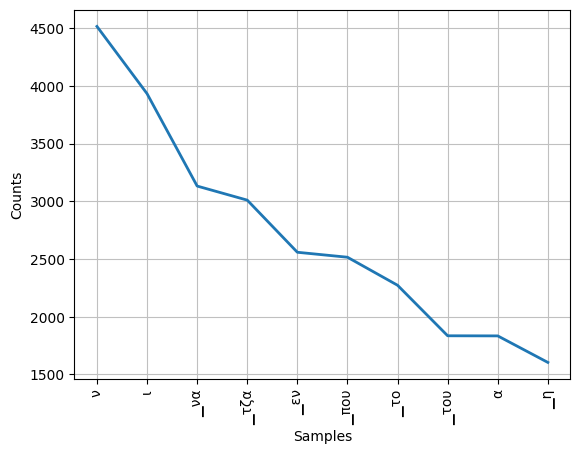

In [13]:
cg_Text.plot(10)
print(cg_Text.vocab().most_common(10))

##### 4.2.1.2 SMG

<Axes: xlabel='Samples', ylabel='Counts'>

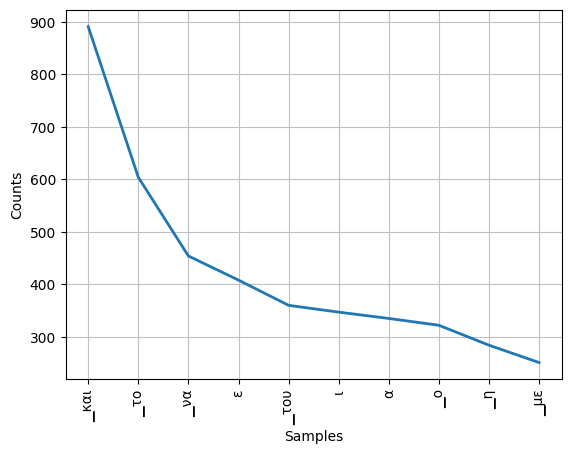

In [14]:
smg_Text.plot(10)

#### 4.2.2 Most frequent characters

##### 4.2.2.1 CG

<Axes: xlabel='Samples', ylabel='Counts'>

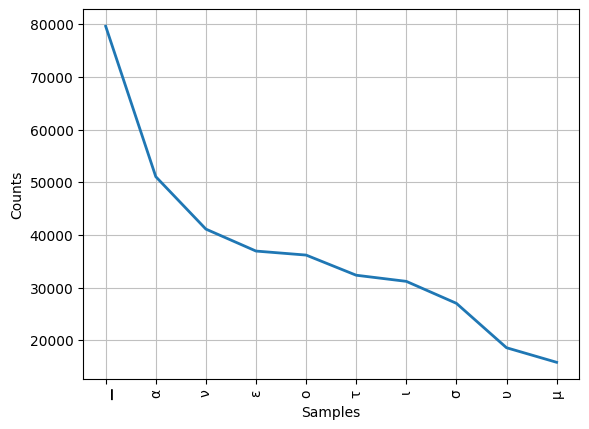

In [15]:
cg_chars_Text.plot(10)

##### 4.2.2.2 SMG

<Axes: xlabel='Samples', ylabel='Counts'>

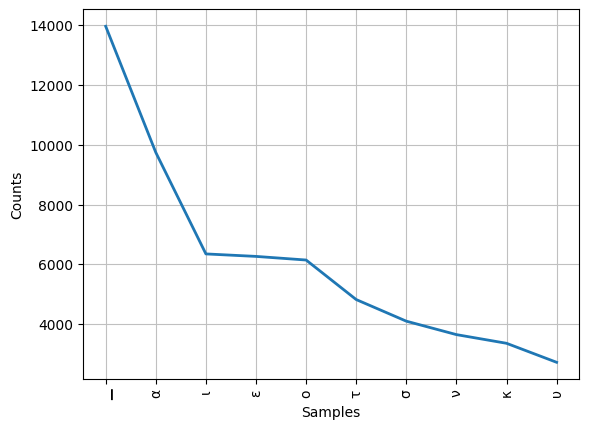

In [16]:
smg_chars_Text.plot(10)

NB: Recall that 'σ' in the most frequent character charts above includes instances of both 'σ' and 'ς'.

### 4.3 Most frequent word n-grams

#### 4.3.1 Bigrams

##### 4.3.1.1 CG

<Axes: xlabel='Samples', ylabel='Counts'>

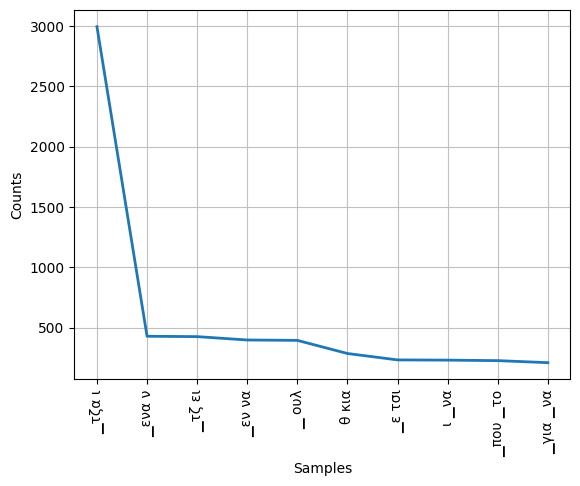

In [17]:
cg_word_bigrams_Text.plot(10)

##### 4.3.1.2 SMG

<Axes: xlabel='Samples', ylabel='Counts'>

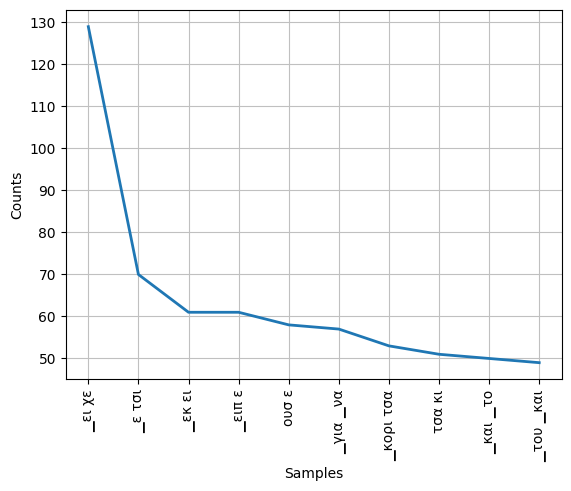

In [18]:
smg_word_bigrams_Text.plot(10)

### 4.4 Most frequent character n-grams

#### 4.4.1 Bigrams

##### 4.4.1.1 CG

<Axes: xlabel='Samples', ylabel='Counts'>

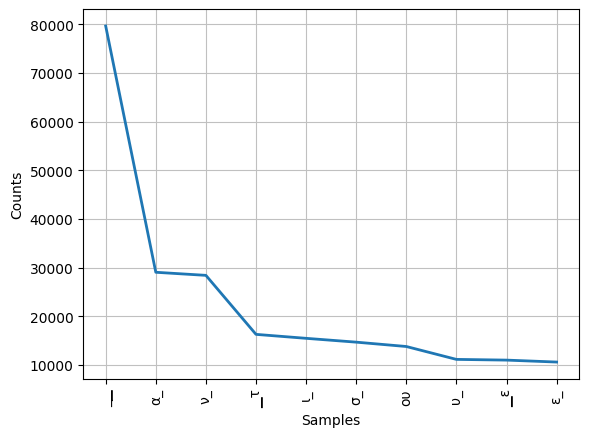

In [19]:
cg_char_bigrams_Text.plot(10)

##### 4.4.1.2 SMG

<Axes: xlabel='Samples', ylabel='Counts'>

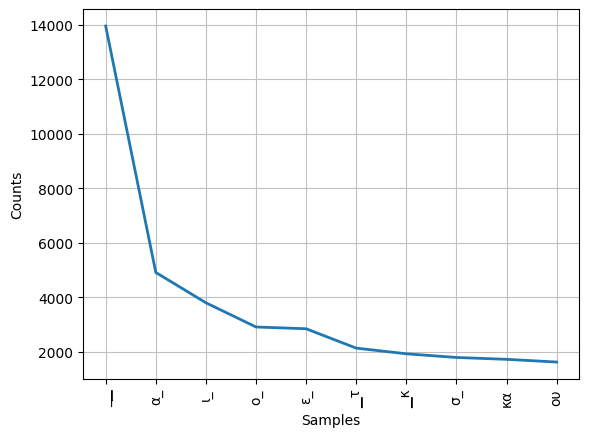

In [20]:
smg_char_bigrams_Text.plot(10)

#### 4.4.2 Trigrams

##### 4.4.2.1 CG

<Axes: xlabel='Samples', ylabel='Counts'>

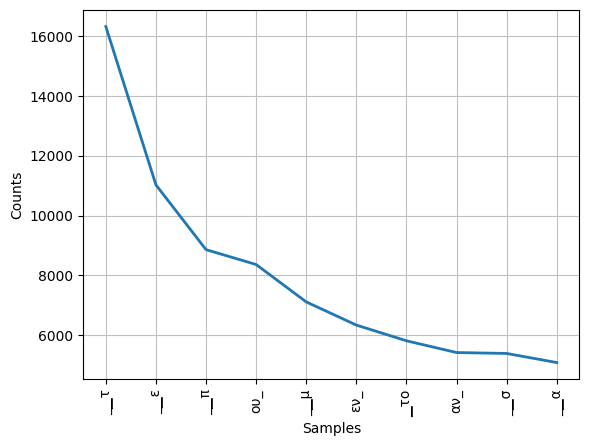

In [21]:
cg_char_trigrams_Text.plot(10)

##### 4.4.2.2 SMG

<Axes: xlabel='Samples', ylabel='Counts'>

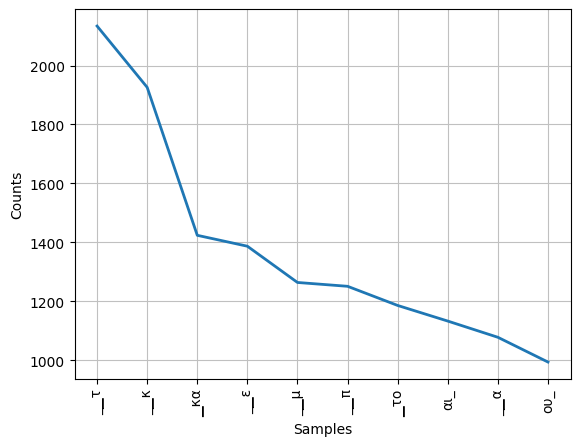

In [22]:
smg_char_trigrams_Text.plot(10)

In [23]:
from collections import Counter

def CyGr_score(eval_sents_tokens, cg_Text, n):

    # Get the top-n most frequent Cypriot tokens from training data
    top_cy_tokens = set(token for token, _ in cg_Text.vocab().most_common(n))

    # Flatten all tokenized sentences into a single list of tokens
    eval_tokens = [token.lower() for sent in eval_sents_tokens for token in sent]

    if len(eval_tokens) == 0:
        return 0.0

    # Count how many tokens are in the top-n Cy tokens
    cy_token_matches = sum(1 for token in eval_tokens if token in top_cy_tokens)


    # Return percentage
    return (cy_token_matches / len(eval_tokens)) * 100

In [24]:
# n = number of top Cypriot tokens to use
n = 10

# This will give you the percent of evaluation tokens that are in the top-n Cy tokens
percent = CyGr_score(eval_sents_tokens, cg_Text, n)
print(f"Cypriot Greek percentage: {percent:.2f}%")

Cypriot Greek percentage: 17.74%


In [30]:
# Flatten eval tokens
eval_tokens = [token.lower() for sent in eval_sents_tokens for token in sent]
eval_counts = Counter(eval_tokens)

# Get training token frequencies from cg_Text
cg_tokens = cg_Text.tokens  # nltk.Text object from training
cg_counts = Counter([token.lower() for token in cg_tokens])


Counter({'▁και': 891, '▁το': 604, '▁να': 454, 'ε': 408, '▁του': 360, 'ι': 347, 'α': 335, '▁ο': 322, '▁η': 284, '▁με': 251, '▁ε': 205, '▁τα': 202, '▁ει': 187, '▁ενα': 186, '▁που': 183, '▁απο': 175, 'ρα': 173, '▁στο': 171, '▁μια': 167, '▁την': 162, '▁': 155, 'κι': 151, 'ει': 147, 'χε': 136, 'η': 136, '▁για': 134, '▁της': 131, '▁τον': 131, 'ο': 130, '▁δεν': 130, 'σει': 126, 'ρ': 122, 'τα': 117, '▁ηταν': 114, '▁θα': 114, 'ς': 108, '▁τι': 104, 'ω': 97, 'ταν': 91, '▁σε': 88, '▁τους': 88, 'τι': 85, 'μα': 84, 'κια': 83, 'ν': 81, 'υ': 81, '▁τη': 81, '▁πολυ': 80, 'σε': 80, 'τσι': 79, '▁εκ': 77, 'ρι': 77, 'τσα': 74, '▁μου': 73, 'λα': 72, '▁σπι': 72, '▁καλα': 70, '▁λιγο': 69, '▁μα': 68, '▁μπα': 68, '▁οτι': 67, '▁ειπ': 65, '▁μετα': 64, '▁α': 63, 'ουσ': 61, 'ουλ': 59, '▁ειναι': 59, '▁αλλα': 58, '▁στην': 57, '▁κορι': 57, 'τε': 56, 'δα': 56, 'τικα': 56, 'να': 56, 'το': 52, '▁κατα': 52, 'γε': 51, '▁αυτο': 51, 'ρο': 50, 'τ': 50, '▁πραγμα': 50, 'τησε': 50, 'ξε': 49, '▁κα': 49, 'ρη': 48, 'ρε': 48, 'κε': 4

In [26]:
import numpy as np

def get_log_rank_freq(counts):
    sorted_items = counts.most_common()
    ranks = np.arange(1, len(sorted_items) + 1)
    freqs = np.array([freq for _, freq in sorted_items])
    return np.log(ranks), np.log(freqs)

log_r_eval, log_f_eval = get_log_rank_freq(eval_counts)
log_r_cg, log_f_cg = get_log_rank_freq(cg_counts)

In [27]:
from sklearn.linear_model import LinearRegression

def fit_zipf_line(log_r, log_f):
    model = LinearRegression()
    model.fit(log_r.reshape(-1, 1), log_f)
    slope = model.coef_[0]
    r_squared = model.score(log_r.reshape(-1, 1), log_f)
    return slope, r_squared

slope_eval, r2_eval = fit_zipf_line(log_r_eval, log_f_eval)
slope_cg, r2_cg = fit_zipf_line(log_r_cg, log_f_cg)

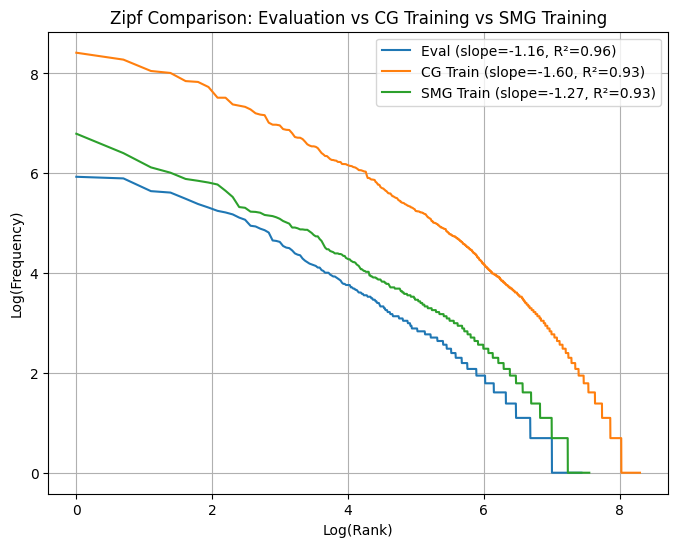

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(log_r_eval, log_f_eval, label=f"Eval (slope={slope_eval:.2f}, R²={r2_eval:.2f})")
plt.plot(log_r_cg, log_f_cg, label=f"CG Train (slope={slope_cg:.2f}, R²={r2_cg:.2f})")
plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.title("Zipf Comparison: Evaluation vs CG Training vs SMG Training")
plt.legend()
plt.grid(True)
plt.show()